In [ ]:
from google.colab import drive
import zipfile
import os

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/Cricket/dataset3/processeddataset.zip'

# Directory where you want to extract the contents
extracted_dir_path = '/content/drive/MyDrive/Cricket/dataset3'

# Create the directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

print("Extraction completed.")

Extraction completed.


get middle frames

normal

In [ ]:
#extract features from all videos
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import cv2
# Load MoveNet model from TensorFlow Hub
model = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
movenet = model.signatures['serving_default']

# Get the list of folders
folders = os.listdir('/content/drive/MyDrive/Cricket/dataset3/processeddataset')

# Initialize an empty list for the features and labels
features = []
labels = []

# Loop over each folder
for i, folder in enumerate(folders):
    # Get the list of videos in the folder
    videos = os.listdir(os.path.join('/content/drive/MyDrive/Cricket/dataset3/processeddataset', folder))
    print(folder)

    # Loop over each video
    for video in videos:
        # Open the video file
        cap = cv2.VideoCapture(os.path.join('/content/drive/MyDrive/Cricket/dataset3/processeddataset', folder, video))

        # Initialize an empty list for the features of the video
        video_features = []
        while(cap.isOpened()):
            # Read a frame from the video
            ret, frame = cap.read()

            if ret:
                # Preprocess the frame
                image = tf.image.resize(frame, [256, 256])
                image = tf.cast(image, dtype=tf.int32)

                # Add an extra dimension
                image = tf.expand_dims(image, axis=0)

                # Run inference
                outputs = movenet(image)

                # Append the outputs to the video features
                video_features.append(outputs['output_0'].numpy())

            else:
                break

        # Release the video file
        cap.release()

        # Append the mean of the video features to the features
#             features.append(np.mean(video_features, axis=0).flatten())
        features.append(np.mean(video_features, axis=0))


        # Append the label to the labels
        labels.append(i)
print('done')

correct_defence
correct_drive
wrong_defence
wrong_drive
done


In [ ]:
features_array = np.array(features)
labels_array = np.array(labels)
print(features_array.shape)
print(labels_array.shape)

(401, 1, 1, 17, 3)
(401,)


In [ ]:
labels_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
from keras.utils import to_categorical

# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=4)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(features_array, labels, test_size=0.2, random_state=42)

#features_train = features_array
#labels_train = labels
# Check the shapes of the training and testing sets
print("Features Train Shape:", features_train.shape)
print("Labels Train Shape:", labels_train.shape)
print("Features Test Shape:", features_test.shape)
print("Labels Test Shape:", labels_test.shape)

Features Train Shape: (320, 1, 1, 17, 3)
Labels Train Shape: (320, 4)
Features Test Shape: (81, 1, 1, 17, 3)
Labels Test Shape: (81, 4)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Define the learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Add it to your callbacks
callbacks = [early_stop, reduce_lr]

# Create a CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(1, 1, 17, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.1))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu'))
#model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(features_train, labels_train, epochs=100, batch_size=4,validation_data=(features_test, labels_test), callbacks=callbacks)

Epoch 1/100
80/80 [==============================] - 2s 7ms/step - loss: 1.9477 - accuracy: 0.3812 - val_loss: 1.7509 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/100
80/80 [==============================] - 0s 4ms/step - loss: 1.4621 - accuracy: 0.4594 - val_loss: 1.5672 - val_accuracy: 0.5185 - lr: 0.0010
Epoch 3/100
80/80 [==============================] - 0s 4ms/step - loss: 1.1964 - accuracy: 0.5906 - val_loss: 1.4373 - val_accuracy: 0.5185 - lr: 0.0010
Epoch 4/100
80/80 [==============================] - 0s 4ms/step - loss: 1.0710 - accuracy: 0.6844 - val_loss: 1.3219 - val_accuracy: 0.6049 - lr: 0.0010
Epoch 5/100
80/80 [==============================] - 0s 4ms/step - loss: 0.9077 - accuracy: 0.7125 - val_loss: 1.1793 - val_accuracy: 0.7531 - lr: 0.0010
Epoch 6/100
80/80 [==============================] - 0s 4ms/step - loss: 0.7946 - accuracy: 0.7750 - val_loss: 0.8961 - val_accuracy: 0.8272 - lr: 0.0010
Epoch 7/100
80/80 [==============================] - 0s 3ms/step - loss: 0.6

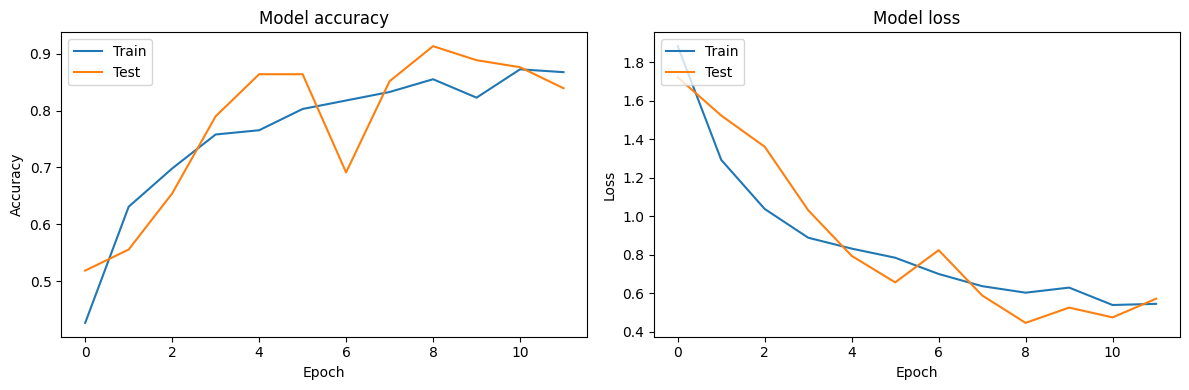

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
model_save_path = '/content/drive/MyDrive/Cricket/modelV3.h5'

# Save the model
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

labels_test_argmax = np.argmax(labels_test, axis=1)

# After the model has been trained, get predictions from the model
predictions = model.predict(features_test)
predictions_argmax = np.argmax(predictions, axis=1)

print(classification_report(labels_test_argmax, predictions_argmax))

3/3 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        35
           1       0.70      1.00      0.82        14
           2       0.61      1.00      0.76        19
           3       1.00      0.69      0.82        13

    accuracy                           0.78        81
   macro avg       0.83      0.82      0.79        81
weighted avg       0.86      0.78      0.78        81



new predict